# Kaggle - Brazilian E-Commerce Public Dataset by Olist
[참고 노트북 | Customer Segmentation & LTV](https://www.kaggle.com/code/richardnnamdi/customer-segmentation-ltv)

### 사용 라이브러리

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import koreanize_matplotlib
import warnings
warnings.filterwarnings("ignore")

### 시각화 함수 정의

In [2]:
def format_spines(ax, right_border=True):
    ax.spines['bottom'].set_color('#666666')
    ax.spines['left'].set_color('#666666')
    ax.spines['top'].set_visible(False)
    if right_border:
        ax.spines['right'].set_color('#FFFFFF')
    else:
        ax.spines['right'].set_color('#FFFFFF')
    ax.patch.set_facecolor('#FFFFFF')
    

def count_plot(feature, df, colors='Blues_d', hue=False, ax=None, title=''):
    ncount = len(df)
    if hue != False:
        ax = sns.countplot(x=feature, data=df, palette=colors, hue=hue, ax=ax)
    else:
        ax = sns.countplot(x=feature, data=df, palette=colors, ax=ax)
    format_spines(ax)

    for p in ax.patches:
        x=p.get_bbox().get_points()[:,0]
        y=p.get_bbox().get_points()[1,1]
        ax.annotate('{:.1f}%'.format(100.*y/ncount), (x.mean(), y), 
                ha='center', va='bottom')
    if not hue:
        ax.set_title(df[feature].describe().name + ' Analysis', size=13, pad=15)
    else:
        ax.set_title(df[feature].describe().name + ' Analysis by ' + hue, size=13, pad=15)  
    if title != '':
        ax.set_title(title)       
    plt.tight_layout()
    
    
def bar_plot(x, y, df, colors='Blues_d', hue=False, ax=None, value=False, title=''):
    try:
        ncount = sum(df[y])
    except:
        ncount = sum(df[x])
    if hue != False:
        ax = sns.barplot(x=x, y=y, data=df, palette=colors, hue=hue, ax=ax, ci=None)
    else:
        ax = sns.barplot(x=x, y=y, data=df, palette=colors, ax=ax, ci=None)
    format_spines(ax)
    for p in ax.patches:
        xp=p.get_bbox().get_points()[:,0]
        yp=p.get_bbox().get_points()[1,1]
        if value:
            ax.annotate('{:.2f}k'.format(yp/1000), (xp.mean(), yp), 
                    ha='center', va='bottom') 
        else:
            ax.annotate('{:.1f}%'.format(100.*yp/ncount), (xp.mean(), yp), 
                    ha='center', va='bottom') 
    if not hue:
        ax.set_title(df[x].describe().name + ' Analysis', size=12, pad=15)
    else:
        ax.set_title(df[x].describe().name + ' Analysis by ' + hue, size=12, pad=15)
    if title != '':
        ax.set_title(title)  
    plt.tight_layout()

### Data Load

In [3]:
customers_ = pd.read_csv("./data/olist_customers_dataset.csv")
order_items_ = pd.read_csv("./data/olist_order_items_dataset.csv")
order_payments_ = pd.read_csv("./data/olist_order_payments_dataset.csv")
orders_ = pd.read_csv("./data/olist_orders_dataset.csv")

dataset = {
    'Customers': customers_,
    'Order Items': order_items_,
    'Payments': order_payments_,
    'Orders': orders_
}

for x, y in dataset.items():
    print(f'{x}', (list(y.shape)))

Customers [99441, 5]
Order Items [112650, 7]
Payments [103886, 5]
Orders [99441, 8]


### EDA
#### Columns Names

In [4]:
for x, y in dataset.items():
    print(f'{x}', f'{list(y.columns)}\n')

Customers ['customer_id', 'customer_unique_id', 'customer_zip_code_prefix', 'customer_city', 'customer_state']

Order Items ['order_id', 'order_item_id', 'product_id', 'seller_id', 'shipping_limit_date', 'price', 'freight_value']

Payments ['order_id', 'payment_sequential', 'payment_type', 'payment_installments', 'payment_value']

Orders ['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date']



#### 결측치 확인

In [6]:
# null values
for x, y in dataset.items():
    print(f"{x}: {y.isnull().any().any()}")

Customers: False
Order Items: False
Payments: False
Orders: True


In [7]:
# missing values
for x, y in dataset.items():
    if y.isnull().any().any():
        print(f'{x}', (list(y.shape)),'\n')
        print(f'{y.isnull().sum()}\n')

Orders [99441, 8] 

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64



#### 통합 데이터 프레임 생성

In [9]:
df1 = pd.merge(left=order_payments_, right=order_items_, on="order_id")
df2 = pd.merge(left=df1, right=orders_, on="order_id")
df = pd.merge(left=df2, right=customers_, on="customer_id")
print(df.shape)

(117601, 22)


In [10]:
df.head()

,order_id,payment_sequential,payment_type,payment_installments,payment_value,order_item_id,product_id,seller_id,shipping_limit_date,price,...,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33,1,af74cc53dcffc8384b29e7abfa41902b,213b25e6f54661939f11710a6fddb871,2018-05-02 22:15:09,79.80,...,delivered,2018-04-25 22:01:49,2018-04-25 22:15:09,2018-05-02 15:20:00,2018-05-09 17:36:51,2018-05-22 00:00:00,708ab75d2a007f0564aedd11139c7708,39801,teofilo otoni,MG
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39,1,a630cc320a8c872f9de830cf121661a3,eaf6d55068dea77334e8477d3878d89e,2018-07-02 11:18:58,17.00,...,delivered,2018-06-26 11:01:38,2018-06-26 11:18:58,2018-06-28 14:18:00,2018-06-29 20:32:09,2018-07-16 00:00:00,a8b9d3a27068454b1c98cc67d4e31e6f,2422,sao paulo,SP
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71,1,2028bf1b01cafb2d2b1901fca4083222,cc419e0650a3c5ba77189a1882b7556a,2017-12-26 09:52:34,56.99,...,delivered,2017-12-12 11:19:55,2017-12-14 09:52:34,2017-12-15 20:13:22,2017-12-18 17:24:41,2018-01-04 00:00:00,6f70c0b2f7552832ba46eb57b1c5651e,2652,sao paulo,SP
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78,1,548e5bfe28edceab6b51fa707cc9556f,da8622b14eb17ae2831f4ac5b9dab84a,2017-12-12 12:13:20,89.90,...,delivered,2017-12-06 12:04:06,2017-12-06 12:13:20,2017-12-07 20:28:28,2017-12-21 01:35:51,2018-01-04 00:00:00,87695ed086ebd36f20404c82d20fca87,36060,juiz de fora,MG
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45,1,386486367c1f9d4f587a8864ccb6902b,cca3071e3e9bb7d12640c9fbe2301306,2018-05-31 16:14:41,113.57,...,delivered,2018-05-21 13:59:17,2018-05-21 16:14:41,2018-05-22 11:46:00,2018-06-01 21:44:53,2018-06-13 00:00:00,4291db0da71914754618cd789aebcd56,18570,conchas,SP


#### Converting DateTime

In [11]:
date_columns = ["shipping_limit_date", "order_purchase_timestamp", "order_approved_at", "order_delivered_carrier_date", "order_delivered_customer_date", "order_estimated_delivery_date"]
for col in date_columns:
    df[col] = pd.to_datetime(df[col], format="%Y-%m-%d %H:%M:%S")

#### Cleaning up name columns

In [12]:
df["customer_city"] = df["customer_city"].str.title()
df["payment_type"] = df["payment_type"].str.replace("_", " ").str.title()

#### 파생 변수 생성

In [13]:
df['delivery_against_estimated'] = (df['order_estimated_delivery_date'] - df['order_delivered_customer_date']).dt.days
df['order_purchase_year'] = df["order_purchase_timestamp"].apply(lambda x: x.year)
df['order_purchase_month'] = df["order_purchase_timestamp"].apply(lambda x: x.month)
df['order_purchase_dayofweek'] = df["order_purchase_timestamp"].apply(lambda x: x.dayofweek)
df['order_purchase_hour'] = df["order_purchase_timestamp"].apply(lambda x: x.hour)
df['order_purchase_day'] = df['order_purchase_dayofweek'].map({0:'Mon',1:'Tue',2:'Wed',3:'Thu',4:'Fri',5:'Sat',6:'Sun'})
df['order_purchase_mon'] = df["order_purchase_timestamp"].apply(lambda x: x.month).map({1:'Jan',2:'Feb',3:'Mar',4:'Apr',5:'May',6:'Jun',7:'Jul',8:'Aug',9:'Sep',10:'Oct',11:'Nov',12:'Dec'})

df['month_year'] = df['order_purchase_month'].astype(str).apply(lambda x: '0' + x if len(x) == 1 else x)
df['month_year'] = df['order_purchase_year'].astype(str) + '-' + df['month_year'].astype(str)

df['month_y'] = df['order_purchase_timestamp'].map(lambda date: 100*date.year + date.month)

#### Summary

In [16]:
df.describe(include="all")

,order_id,payment_sequential,payment_type,payment_installments,payment_value,order_item_id,product_id,seller_id,shipping_limit_date,price,...,customer_state,delivery_against_estimated,order_purchase_year,order_purchase_month,order_purchase_dayofweek,order_purchase_hour,order_purchase_day,order_purchase_mon,month_year,month_y
count,117601,117601.000000,117601,117601.000000,117601.000000,117601.000000,117601,117601,117601,117601.000000,...,117601,115034.000000,117601.000000,117601.000000,117601.000000,117601.000000,117601,117601,117601,117601.000000
unique,98665,NaN,4,NaN,NaN,NaN,32951,3095,93317,NaN,...,27,NaN,NaN,NaN,NaN,NaN,7,12,24,NaN
top,895ab968e7bb0d5659d16cd74cd1650c,NaN,Credit Card,NaN,NaN,NaN,aca2eb7d00ea1a7b8ebd4e68314663af,4a3ca9315b744ce9f8e9374361493884,2017-08-14 20:43:31,NaN,...,SP,NaN,NaN,NaN,NaN,NaN,Mon,Aug,2017-11,NaN
freq,63,NaN,86769,NaN,NaN,NaN,536,2133,63,NaN,...,49566,NaN,NaN,NaN,NaN,NaN,19130,12632,9016,NaN
first,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-09-19 00:15:34,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-04-09 22:35:08,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,1.093528,NaN,2.939482,172.686752,1.195900,NaN,NaN,NaN,120.824783,...,NaN,11.043326,2017.538193,6.028129,2.745750,14.760002,NaN,NaN,NaN,201759.847399
std,NaN,0.726692,NaN,2.774223,267.592290,0.697706,NaN,NaN,NaN,184.479323,...,NaN,10.162307,0.505065,3.229579,1.961257,5.325670,NaN,NaN,NaN,48.798820
min,NaN,1.000000,NaN,0.000000,0.000000,1.000000,NaN,NaN,NaN,0.850000,...,NaN,-189.000000,2016.000000,1.000000,0.000000,0.000000,NaN,NaN,NaN,201609.000000
25%,NaN,1.000000,NaN,1.000000,60.870000,1.000000,NaN,NaN,NaN,39.900000,...,NaN,6.000000,2017.000000,3.000000,1.000000,11.000000,NaN,NaN,NaN,201709.000000


#### 결측치 개수와 비율 확인

In [17]:
missing_values = df.isnull().sum().sort_values(ascending = False)
percentage = (df.isnull().sum()/df.isnull().count()*100).sort_values(ascending = False)
pd.concat([missing_values, percentage], axis=1, keys=['Values', 'Percentage']).transpose()

,order_delivered_customer_date,delivery_against_estimated,order_delivered_carrier_date,order_approved_at,month_year,order_purchase_mon,order_purchase_day,order_purchase_hour,order_purchase_dayofweek,order_purchase_month,...,freight_value,price,shipping_limit_date,seller_id,product_id,order_item_id,payment_value,payment_installments,payment_type,month_y
Values,2567.000000,2567.000000,1245.000000,15.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Percentage,2.182805,2.182805,1.058664,0.012755,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
# 결측치 버리기
df.dropna(inplace=True)
df.isnull().values.any()

False

#### Monthly Revenue

In [19]:
df_revenue = df.groupby("month_year")["payment_value"].sum().reset_index()
df_revenue

,month_year,payment_value
0,2016-10,62591.65
1,2016-12,19.62
2,2017-01,176376.56
3,2017-02,323815.95
4,2017-03,505735.83
5,2017-04,456108.32
6,2017-05,701119.60
7,2017-06,585400.98
8,2017-07,716069.98
9,2017-08,842689.94


#### Monthly Revenue Growth Rate

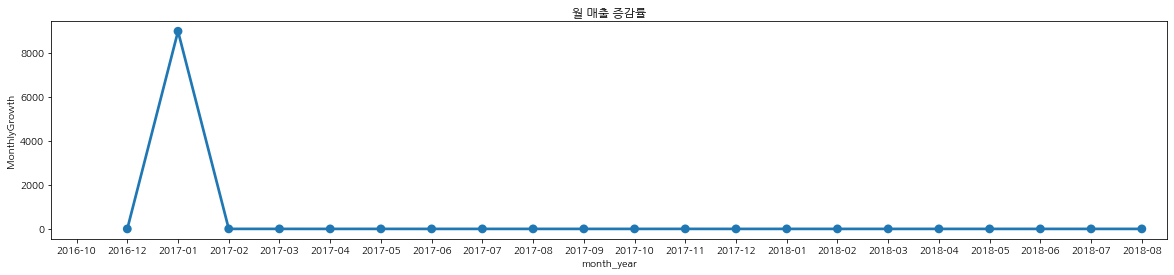

In [24]:
df_revenue["MonthlyGrowth"] = df_revenue["payment_value"].pct_change()
plt.figure(figsize=(20, 4))
_ = sns.pointplot(data=df_revenue, x="month_year", y="MonthlyGrowth", ci=None).set_title("월 매출 증감률")

#### Monthly Active Customers

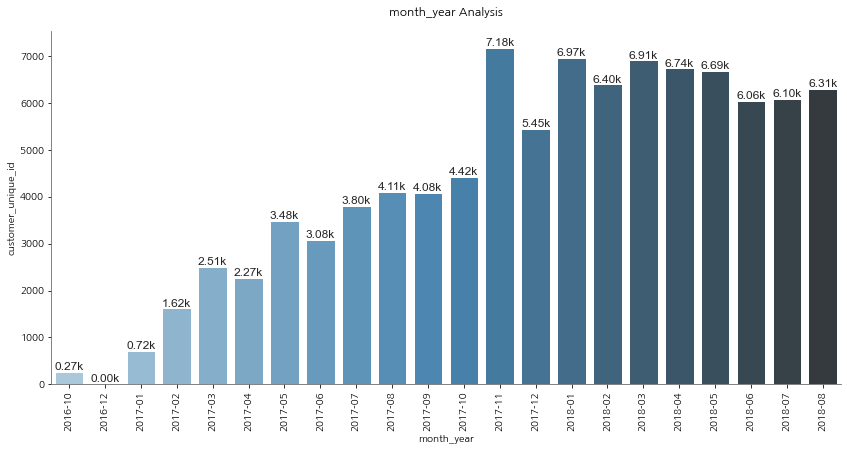

In [26]:
df_monthly_active = df.groupby("month_year")["customer_unique_id"].nunique().reset_index()

fig, ax = plt.subplots(figsize=(12, 6))
sns.set(palette="muted", color_codes=True, style="whitegrid")
bar_plot(x="month_year", y="customer_unique_id", df=df_monthly_active, value=True)
ax.tick_params(axis="x", labelrotation=90)
plt.show()

#### Monthly Order Count

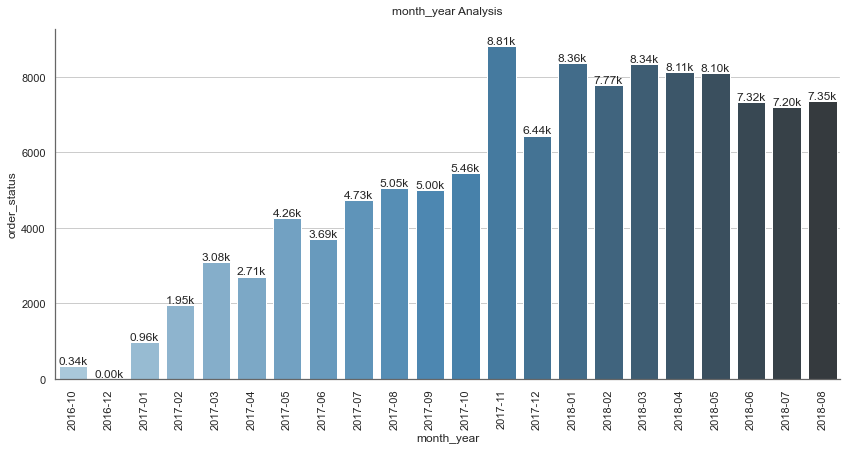

In [27]:
df_monthly_sales = df.groupby("month_year")["order_status"].count().reset_index()

fig, ax = plt.subplots(figsize=(12, 6))
sns.set(palette="muted", color_codes=True, style="whitegrid")
bar_plot(x="month_year", y="order_status", df=df_monthly_sales, value=True)
ax.tick_params(axis="x", labelrotation=90)
plt.show()

#### ARPU (Average Revenue per Customer Purchase)

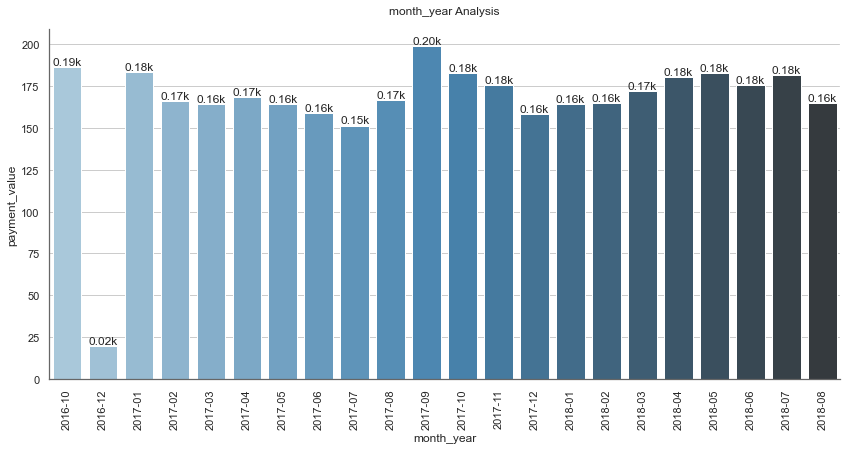

In [28]:
df_monthly_order_avg = df.groupby('month_year')['payment_value'].mean().reset_index()

fig, ax = plt.subplots(figsize=(12, 6))
sns.set(palette='muted', color_codes=True, style='whitegrid')
bar_plot(x='month_year', y='payment_value', df=df_monthly_order_avg, value=True)
ax.tick_params(axis='x', labelrotation=90)
plt.show()

#### 신규 가입자 비율

In [29]:
df_min_purchase = df.groupby('customer_unique_id')["order_purchase_timestamp"].min().reset_index()
df_min_purchase.columns = ['customer_unique_id','minpurchasedate']
df_min_purchase['minpurchasedate'] = df_min_purchase['minpurchasedate'].map(lambda date: 100*date.year + date.month)

df = pd.merge(df, df_min_purchase, on='customer_unique_id')

df['usertype'] = 'New'
df.loc[df['month_y']>df['minpurchasedate'],'usertype'] = 'Existing'

df_user_type_revenue = df.groupby(['month_y','usertype', 'month_year'])['payment_value'].sum().reset_index()

df_user_type_revenue

,month_y,usertype,month_year,payment_value
0,201610,New,2016-10,62591.65
1,201612,New,2016-12,19.62
2,201701,Existing,2017-01,19.62
3,201701,New,2017-01,176356.94
4,201702,Existing,2017-02,111.07
5,201702,New,2017-02,323704.88
6,201703,Existing,2017-03,596.38
7,201703,New,2017-03,505139.45
8,201704,Existing,2017-04,2789.06
9,201704,New,2017-04,453319.26


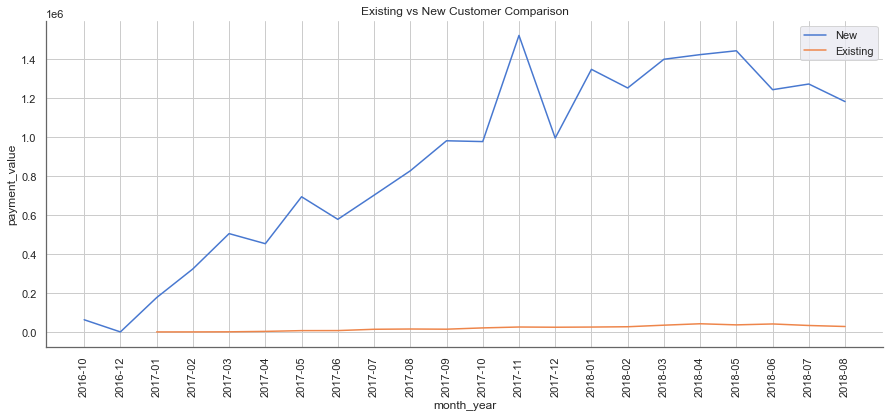

In [30]:
fig, ax = plt.subplots(figsize=(15, 6))
sns.set(palette='muted', color_codes=True)
ax = sns.lineplot(x='month_year', y='payment_value', data=df_user_type_revenue.query("usertype == 'New'"), label='New')
ax = sns.lineplot(x='month_year', y='payment_value', data=df_user_type_revenue.query("usertype == 'Existing'"), label='Existing')
format_spines(ax, right_border=False)
ax.set_title('Existing vs New Customer Comparison')
ax.tick_params(axis='x', labelrotation=90)
plt.show()

In [31]:
df_user_ratio = df.query("usertype == 'New'").groupby(['month_year'])['customer_unique_id'].nunique()/df.query("usertype == 'Existing'").groupby(['month_year'])['customer_unique_id'].nunique() 
df_user_ratio = df_user_ratio.reset_index()

df_user_ratio = df_user_ratio.dropna()
df_user_ratio.columns = ['month_year','NewCusRatio']

df_user_ratio

,month_year,NewCusRatio
2,2017-01,715.000000
3,2017-02,808.000000
4,2017-03,500.600000
5,2017-04,125.333333
6,2017-05,123.214286
7,2017-06,77.871795
8,2017-07,75.040000
9,2017-08,71.175439
10,2017-09,50.670886
11,2017-10,49.193182


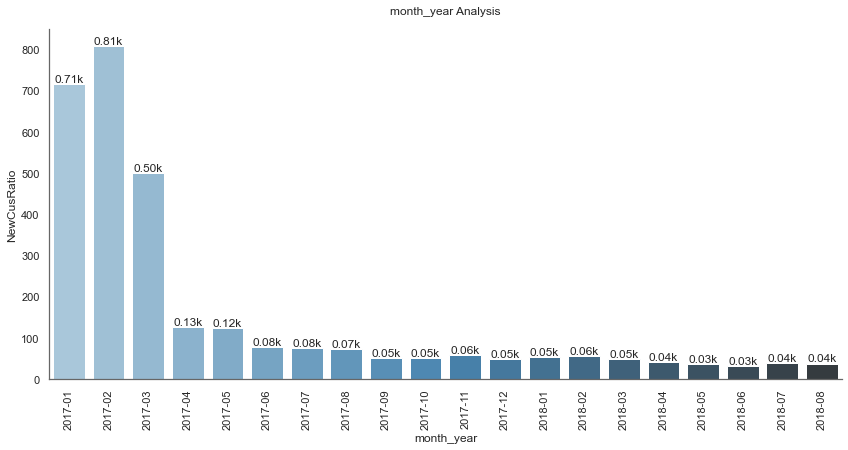

In [32]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.set(palette='muted', color_codes=True, style='whitegrid')
bar_plot(x='month_year', y='NewCusRatio', df=df_user_ratio, value=True)
ax.tick_params(axis='x', labelrotation=90)
plt.show()

#### Monthly Retention Rate

In [33]:
df_user_purchase = df.groupby(['customer_unique_id','month_y'])['payment_value'].sum().reset_index()
df_user_purchase.head()

,customer_unique_id,month_y,payment_value
0,0000366f3b9a7992bf8c76cfdf3221e2,201805,141.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,201805,27.19
2,0000f46a3911fa3c0805444483337064,201703,86.22
3,0000f6ccb0745a6a4b88665a16c9f078,201710,43.62
4,0004aac84e0df4da2b147fca70cf8255,201711,196.89


In [34]:
df_user_purchase = df.groupby(['customer_unique_id','month_y'])['payment_value'].count().reset_index()
df_user_purchase.head()

,customer_unique_id,month_y,payment_value
0,0000366f3b9a7992bf8c76cfdf3221e2,201805,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,201805,1
2,0000f46a3911fa3c0805444483337064,201703,1
3,0000f6ccb0745a6a4b88665a16c9f078,201710,1
4,0004aac84e0df4da2b147fca70cf8255,201711,1


In [35]:
df_retention = pd.crosstab(df_user_purchase['customer_unique_id'], df_user_purchase['month_y']).reset_index()
df_retention.head()

month_y,customer_unique_id,201610,201612,201701,201702,201703,201704,201705,201706,201707,...,201711,201712,201801,201802,201803,201804,201805,201806,201807,201808
0,0000366f3b9a7992bf8c76cfdf3221e2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,0000f46a3911fa3c0805444483337064,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0000f6ccb0745a6a4b88665a16c9f078,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0004aac84e0df4da2b147fca70cf8255,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [36]:
months = df_retention.columns[2:]
retention_array = []
for i in range(len(months)-1):
    retention_data = {}
    selected_month = months[i+1]
    prev_month = months[i]
    retention_data['month_y'] = int(selected_month)
    retention_data['TotalUserCount'] = df_retention[selected_month].sum()
    retention_data['RetainedUserCount'] = df_retention[(df_retention[selected_month]>0) & (df_retention[prev_month]>0)][selected_month].sum()
    retention_array.append(retention_data)
    
df_retention = pd.DataFrame(retention_array)
df_retention['RetentionRate'] = df_retention['RetainedUserCount']/df_retention['TotalUserCount']

df_retention

,month_y,TotalUserCount,RetainedUserCount,RetentionRate
0,201701,716,1,0.001397
1,201702,1618,2,0.001236
2,201703,2508,3,0.001196
3,201704,2274,11,0.004837
4,201705,3478,14,0.004025
5,201706,3076,16,0.005202
6,201707,3802,16,0.004208
7,201708,4114,23,0.005591
8,201709,4082,32,0.007839
9,201710,4417,32,0.007245


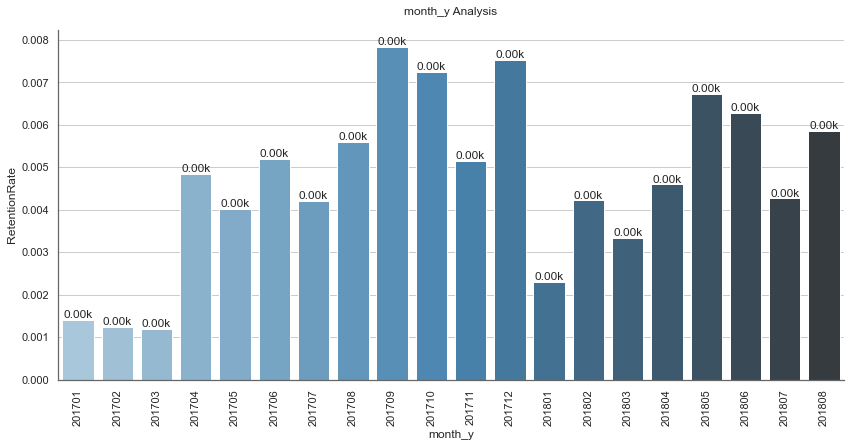

In [37]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.set(palette='muted', color_codes=True, style='whitegrid')
bar_plot(x='month_y', y='RetentionRate', df=df_retention, value=True)
ax.tick_params(axis='x', labelrotation=90)
plt.show()

#### Cohort Based Retention Rate 

In [38]:
df_retention = pd.crosstab(df_user_purchase['customer_unique_id'], df_user_purchase['month_y']).reset_index()
new_column_names = [ 'm_' + str(column) for column in df_retention.columns]
df_retention.columns = new_column_names

retention_array = []
for i in range(len(months)):
    retention_data = {}
    selected_month = months[i]
    prev_months = months[:i]
    next_months = months[i+1:]
    for prev_month in prev_months:
        retention_data[prev_month] = np.nan
        
    total_user_count =  retention_data['TotalUserCount'] = df_retention['m_' + str(selected_month)].sum()
    retention_data[selected_month] = 1 
    
    query = "{} > 0".format('m_' + str(selected_month))
    

    for next_month in next_months:
        query = query + " and {} > 0".format(str('m_' + str(next_month)))
        retention_data[next_month] = np.round(df_retention.query(query)['m_' + str(next_month)].sum()/total_user_count,2)
    retention_array.append(retention_data)
    
    retention_array = []
for i in range(len(months)):
    retention_data = {}
    selected_month = months[i]
    prev_months = months[:i]
    next_months = months[i+1:]
    for prev_month in prev_months:
        retention_data[prev_month] = np.nan
        
    total_user_count =  retention_data['TotalUserCount'] = df_retention['m_' + str(selected_month)].sum()
    retention_data[selected_month] = 1 
    
    query = "{} > 0".format('m_' + str(selected_month))
    

    for next_month in next_months:
        query = query + " and {} > 0".format(str('m_' + str(next_month)))
        retention_data[next_month] = np.round(df_retention.query(query)['m_' + str(next_month)].sum()/total_user_count,2)
    retention_array.append(retention_data)
    
df_retention = pd.DataFrame(retention_array)
df_retention.index = months

df_retention

,TotalUserCount,201612,201701,201702,201703,201704,201705,201706,201707,201708,...,201711,201712,201801,201802,201803,201804,201805,201806,201807,201808
month_y,,,,,,,,,,,,,,,,,,,,,
201612,1,1.0,1.0,0.0,0.0,0.0,0.00,0.0,0.00,0.00,...,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.00
201701,716,NaN,1.0,0.0,0.0,0.0,0.00,0.0,0.00,0.00,...,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.00
201702,1618,NaN,NaN,1.0,0.0,0.0,0.00,0.0,0.00,0.00,...,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.00
201703,2508,NaN,NaN,NaN,1.0,0.0,0.00,0.0,0.00,0.00,...,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.00
201704,2274,NaN,NaN,NaN,NaN,1.0,0.01,0.0,0.00,0.00,...,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.00
201705,3478,NaN,NaN,NaN,NaN,NaN,1.00,0.0,0.00,0.00,...,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.00
201706,3076,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.01,0.00,...,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.00
201707,3802,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.00,0.01,...,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.00
201708,4114,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.00,...,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.00


### RFM
#### Recency

In [39]:
df_user = pd.DataFrame(df['customer_unique_id'])
df_user.columns = ['customer_unique_id']
df_max_purchase = df.groupby('customer_unique_id')["order_purchase_timestamp"].max().reset_index()
df_max_purchase.columns = ['customer_unique_id', 'MaxPurchaseDate']
df_max_purchase['Recency'] = (df_max_purchase['MaxPurchaseDate'].max() - df_max_purchase['MaxPurchaseDate']).dt.days

df_user = pd.merge(df_user, df_max_purchase[['customer_unique_id','Recency']], on='customer_unique_id')

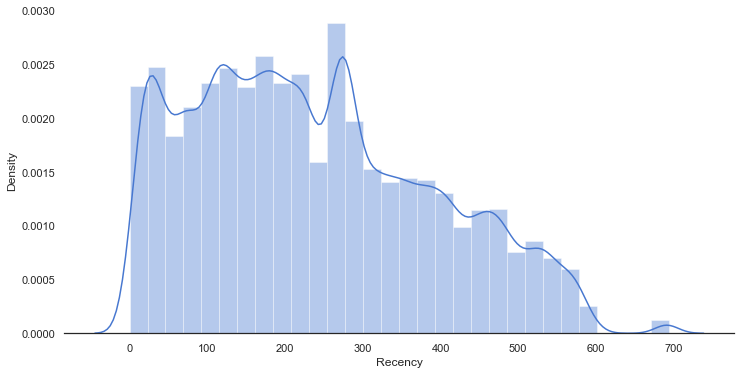

In [40]:
sns.set(palette='muted', color_codes=True, style='white')
fig, ax = plt.subplots(figsize=(12, 6))
sns.despine(left=True)
sns.distplot(df_user['Recency'], bins=30)
plt.show()

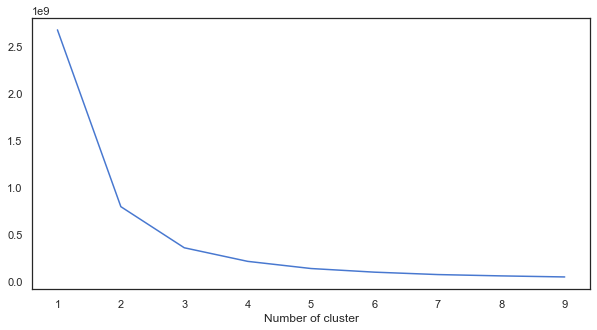

In [41]:
# 군집화
from sklearn.cluster import KMeans

sse={}
df_recency = df_user[['Recency']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(df_recency)
    df_recency["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_
    
plt.figure(figsize=(10, 5))
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

In [42]:
kmeans = KMeans(n_clusters=5)
kmeans.fit(df_user[['Recency']])
df_user['RecencyCluster'] = kmeans.predict(df_user[['Recency']])

#function for ordering cluster numbers
def order_cluster(cluster_field_name, target_field_name,df,ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final

df_user = order_cluster('RecencyCluster', 'Recency',df_user,False)

In [43]:
df_user.groupby('RecencyCluster')['Recency'].describe()

,count,mean,std,min,25%,50%,75%,max
RecencyCluster,,,,,,,,
0,13777.0,512.656311,48.794950,448.0,473.0,506.0,543.0,694.0
1,18773.0,381.158259,35.208183,323.0,350.0,380.0,410.0,447.0
2,27171.0,263.266755,31.174965,210.0,234.0,267.0,285.0,322.0
3,30594.0,154.050042,31.607872,102.0,126.0,155.0,182.0,209.0
4,24703.0,48.616646,28.030105,0.0,24.0,44.0,73.0,101.0


#### Frequency

In [44]:
df_frequency = df.groupby('customer_unique_id').order_purchase_timestamp.count().reset_index()
df_frequency.columns = ['customer_unique_id','Frequency']

df_user = pd.merge(df_user, df_frequency, on='customer_unique_id')

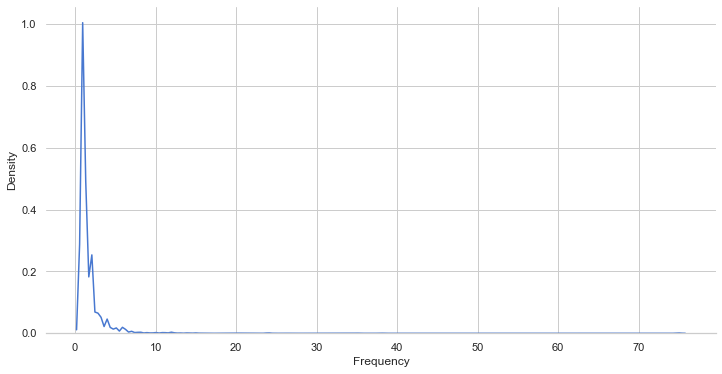

In [45]:
sns.set(palette='muted', color_codes=True, style='whitegrid')
fig, ax = plt.subplots(figsize=(12, 6))
sns.despine(left=True)
sns.distplot(df_user['Frequency'], hist=False)
plt.show()

In [47]:
# 군집화
kmeans = KMeans(n_clusters=5)
kmeans.fit(df_user[['Frequency']])
df_user['FrequencyCluster'] = kmeans.predict(df_user[['Frequency']])

df_user = order_cluster('FrequencyCluster', 'Frequency',df_user,True)

df_user.groupby('FrequencyCluster')['Frequency'].describe()

,count,mean,std,min,25%,50%,75%,max
FrequencyCluster,,,,,,,,
0,100150.0,1.207968,0.405856,1.0,1.0,1.0,1.0,2.0
1,12428.0,3.921307,1.048323,3.0,3.0,4.0,5.0,6.0
2,1968.0,9.850610,2.563686,7.0,7.0,9.0,12.0,16.0
3,397.0,24.536524,6.099081,18.0,20.0,22.0,24.0,38.0
4,75.0,75.000000,0.000000,75.0,75.0,75.0,75.0,75.0


#### Revenue

In [48]:
df_revenue = df.groupby('customer_unique_id').payment_value.sum().reset_index()

df_user = pd.merge(df_user, df_revenue, on='customer_unique_id')

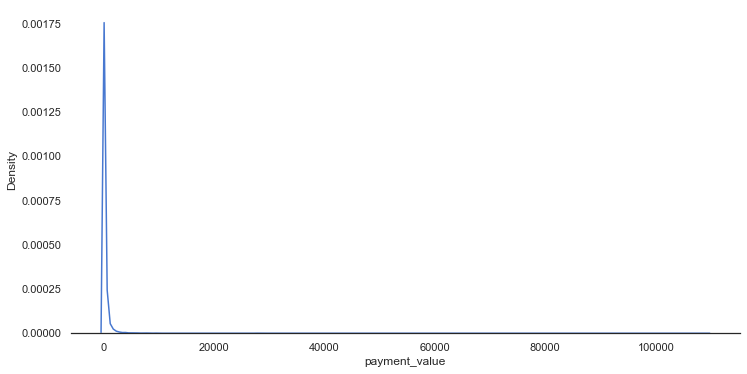

In [49]:
sns.set(palette='muted', color_codes=True, style='white')
fig, ax = plt.subplots(figsize=(12, 6))
sns.despine(left=True)
sns.distplot(df_user['payment_value'], hist=False)
plt.show()

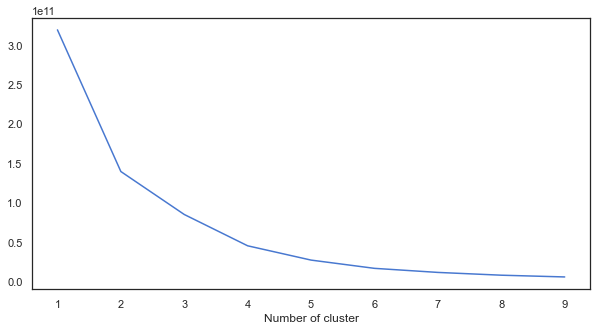

In [50]:
sse={}
df_revenue = df_user[['payment_value']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(df_revenue)
    df_revenue["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_
    
plt.figure(figsize=(10, 5))
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

In [51]:
kmeans = KMeans(n_clusters=6)
kmeans.fit(df_user[['payment_value']])
df_user['RevenueCluster'] = kmeans.predict(df_user[['payment_value']])

df_user = order_cluster('RevenueCluster', 'payment_value',df_user,True)

df_user.groupby('RevenueCluster')['payment_value'].describe()

,count,mean,std,min,25%,50%,75%,max
RevenueCluster,,,,,,,,
0,108472.0,192.576355,191.057389,9.59,67.53,124.24,233.535,1033.12
1,5565.0,1881.126228,817.833740,1034.06,1252.81,1608.36,2218.000,4415.96
2,743.0,7000.283419,2137.860492,4447.80,5289.12,6317.22,7971.880,12490.88
3,184.0,20278.110435,5207.417793,14196.28,16313.60,19174.38,25051.890,30186.00
4,46.0,43587.292174,2837.177072,36489.24,44048.00,44048.00,45256.000,45256.00
5,8.0,109312.640000,0.000000,109312.64,109312.64,109312.64,109312.640,109312.64


#### Overall Score

In [52]:
df_user.columns = ['customer_unique_id', 'Recency', 'RecencyCluster', 'Frequency', 'FrequencyCluster', 'Monetary', 'RevenueCluster']

df_user['OverallScore'] = df_user['RecencyCluster'] + df_user['FrequencyCluster'] + df_user['RevenueCluster']
df_user.groupby('OverallScore')['Recency','Frequency','Monetary'].mean()

,Recency,Frequency,Monetary
OverallScore,,,
0,511.759001,1.207100,167.861348
1,390.772210,1.352797,195.827734
2,276.351342,1.468897,222.252763
3,170.635585,1.577970,251.513166
4,70.135504,1.674742,306.303808
5,105.696962,5.948294,1120.916258
6,99.065306,6.785034,3074.301905
7,110.812245,11.448980,5401.498551
8,143.403226,11.462366,22318.521129


In [53]:
df_user['Segment'] = 'Low-Value'
df_user.loc[df_user['OverallScore']>3,'Segment'] = 'Mid-Value' 
df_user.loc[df_user['OverallScore']>6,'Segment'] = 'High-Value' 

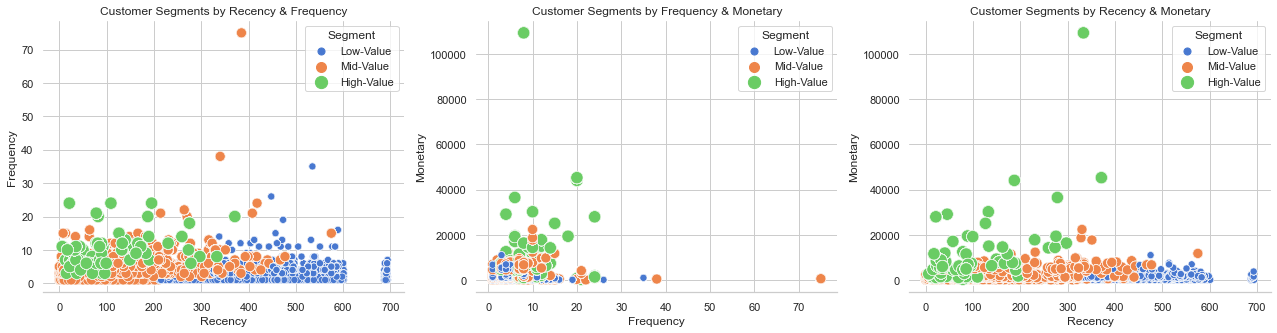

In [54]:
sns.set(palette='muted', color_codes=True, style='whitegrid')
fig, axs = plt.subplots(1, 3, figsize=(22, 5))
sns.despine(left=True)
sns.scatterplot(x='Recency', y='Frequency', ax=axs[0], hue='Segment', data=df_user, size='Segment', sizes=(50,150), size_order=['High-Value','Mid-Value','Low-Value'])
sns.scatterplot(x='Frequency', y='Monetary', ax=axs[1], hue='Segment', data=df_user, size='Segment' , sizes=(50,150), size_order=['High-Value','Mid-Value','Low-Value'])
sns.scatterplot(x='Recency', y='Monetary', ax=axs[2], hue='Segment', data=df_user, size='Segment' , sizes=(50,150), size_order=['High-Value','Mid-Value','Low-Value'])
axs[0].set_title('Customer Segments by Recency & Frequency')
axs[1].set_title('Customer Segments by Frequency & Monetary')
axs[2].set_title('Customer Segments by Recency & Monetary')
plt.show()